## Metrics and evaluation - Bank Marketing Dataset

In this exercise you will create a classification model to predict whether a client will subscribe to a term deposit or not. You will evaluate the model using different metrics and techniques.

The dataset is hosted in [Kaggle](https://www.kaggle.com/datasets/janiobachmann/bank-marketing-dataset), although originally published by [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/222/bank+marketing)
You can also download it manually and update the `path` variable to the appropriate directory in your local environment.

Run the following cell to download the dataset using `kagglehub` package.

In [1]:
import kagglehub
import pandas

# Download latest version
path = kagglehub.dataset_download("janiobachmann/bank-marketing-dataset")

print("Path to dataset files:", path)

C:\Users\fiona\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\fiona\.cache\kagglehub\datasets\janiobachmann\bank-marketing-dataset\versions\1


In [2]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer, FunctionTransformer
from sklearn.compose import ColumnTransformer

In [3]:
# The `path` variable points to the directory of the downloaded files.
# We are interested in the `bank.csv` file specifically.
filepath = Path(path) / Path("bank.csv")

data = pd.read_csv(filepath)

data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


## EDA

Let's start by exploring the dataset and understanding the features and target variable.
Here is the list of all features in the dataset:

In [4]:
data.info()

<class 'pandas.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   age        11162 non-null  int64
 1   job        11162 non-null  str  
 2   marital    11162 non-null  str  
 3   education  11162 non-null  str  
 4   default    11162 non-null  str  
 5   balance    11162 non-null  int64
 6   housing    11162 non-null  str  
 7   loan       11162 non-null  str  
 8   contact    11162 non-null  str  
 9   day        11162 non-null  int64
 10  month      11162 non-null  str  
 11  duration   11162 non-null  int64
 12  campaign   11162 non-null  int64
 13  pdays      11162 non-null  int64
 14  previous   11162 non-null  int64
 15  poutcome   11162 non-null  str  
 16  deposit    11162 non-null  str  
dtypes: int64(7), str(10)
memory usage: 1.4 MB


Additionally, the description of the database in the UCI repository provides more context on each feature:

| Variable Name | Role | Type | Demographic | Description | Units | Missing Values |
|---------------|------|------|-------------|-------------|-------|----------------|
| age           | Feature | Integer | Age | | | no |
| job           | Feature | Categorical | Occupation | type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown') | | no |
| marital       | Feature | Categorical | Marital Status | marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed) | | no |
| education     | Feature | Categorical | Education Level | (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown') | | no |
| default       | Feature | Binary | | has credit in default? | | no |
| balance       | Feature | Integer | | average yearly balance | euros | no |
| housing       | Feature | Binary | | has housing loan? | | no |
| loan          | Feature | Binary | | has personal loan? | | no |
| contact       | Feature | Categorical | | contact communication type (categorical: 'cellular','telephone') | | yes |
| day           | Feature | Date | | last contact day of the week | | no |
| month         | Feature | Date | | last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec') | | no |
| duration      | Feature | Integer | | last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model. | | no |
| campaign      | Feature | Integer | | number of contacts performed during this campaign and for this client (numeric, includes last contact) | | no |
| pdays         | Feature | Integer | | number of days that passed by after the client was last contacted from a previous campaign (numeric; -1 means client was not previously contacted) | | yes |
| previous      | Feature | Integer | | number of contacts performed before this campaign and for this client | | no |
| poutcome      | Feature | Categorical | | outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success') | | yes |
| deposit       | Target | Binary | | has the client subscribed a term deposit? | | |


### Target variable analysis

Our target variable is `deposit`, which indicates whether a client has subscribed to a term deposit or not.

Text(0.5, 1.0, "Distribution of target variable 'deposit'")

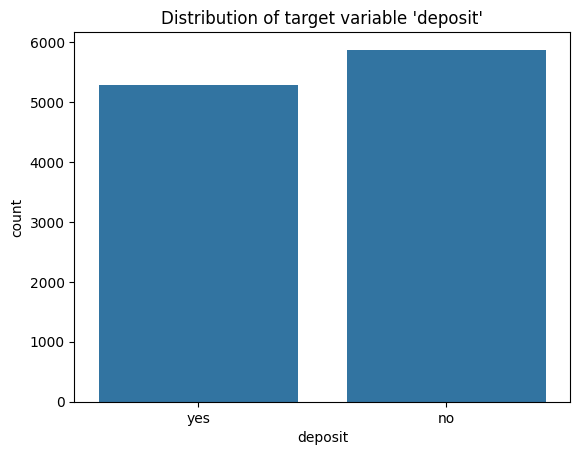

In [5]:
sns.countplot(data=data, x="deposit")
plt.title("Distribution of target variable 'deposit'")

### Feature analysis

Let's start by understanding the descriptive statistics of the dataset.

In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,11162.0,41.231948,11.913369,18.0,32.0,39.0,49.00,95.0
balance,11162.0,1528.538524,3225.413326,-6847.0,122.0,550.0,1708.00,81204.0
day,11162.0,15.658036,8.420740,1.0,8.0,15.0,22.00,31.0
duration,11162.0,371.993818,347.128386,2.0,138.0,255.0,496.00,3881.0
campaign,11162.0,2.508421,2.722077,1.0,1.0,2.0,3.00,63.0
pdays,11162.0,51.330407,108.758282,-1.0,-1.0,-1.0,20.75,854.0
previous,11162.0,0.832557,2.292007,0.0,0.0,0.0,1.00,58.0


We can also visualize the distribution of numerical features.

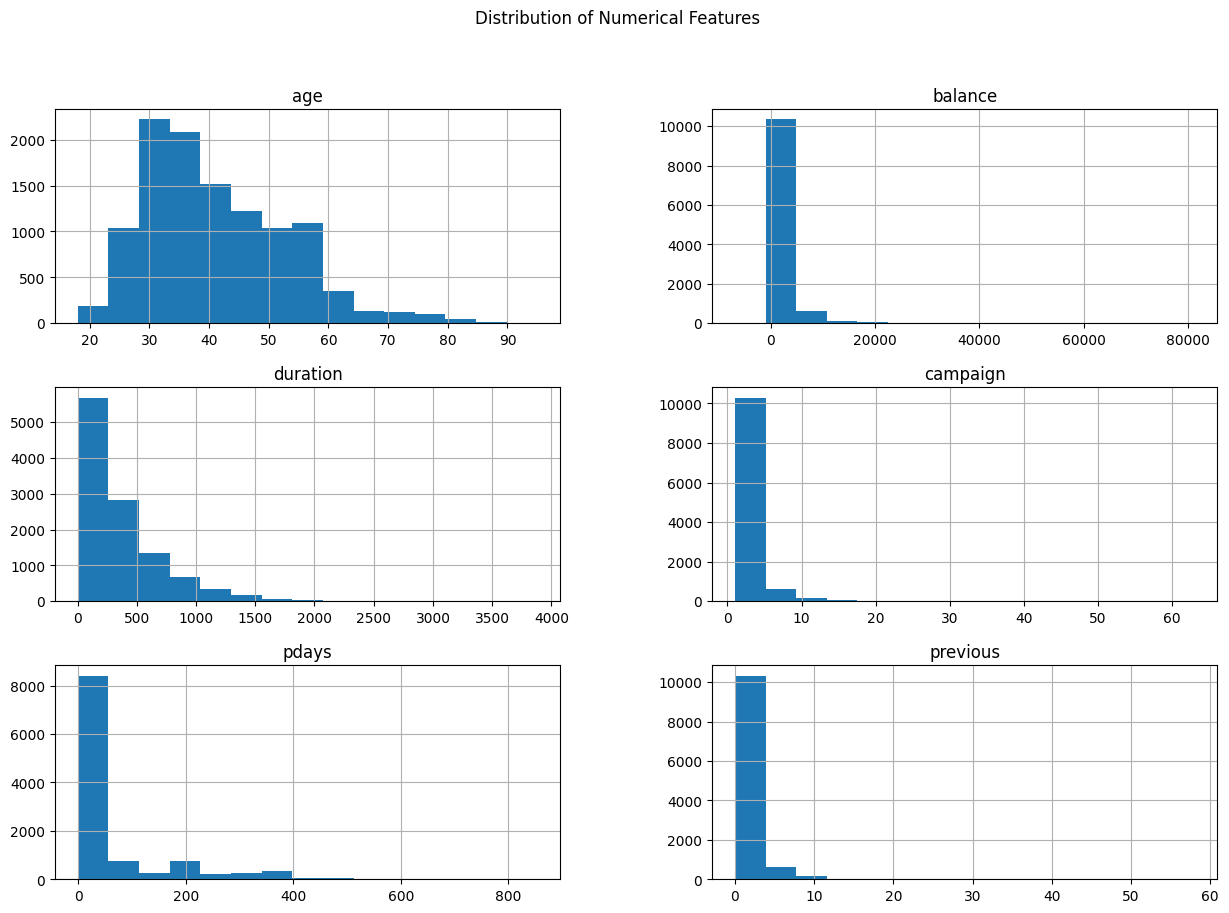

In [7]:
numerical_features = ["age", "balance", "duration", "campaign", "pdays", "previous"]

data[numerical_features].hist(bins=15, figsize=(15, 10))
plt.suptitle("Distribution of Numerical Features")
plt.show()

Let's also look at the distribution of categorical features. Note that we are considering day and month as categorical features for this analysis, since they have a limited number of unique values.

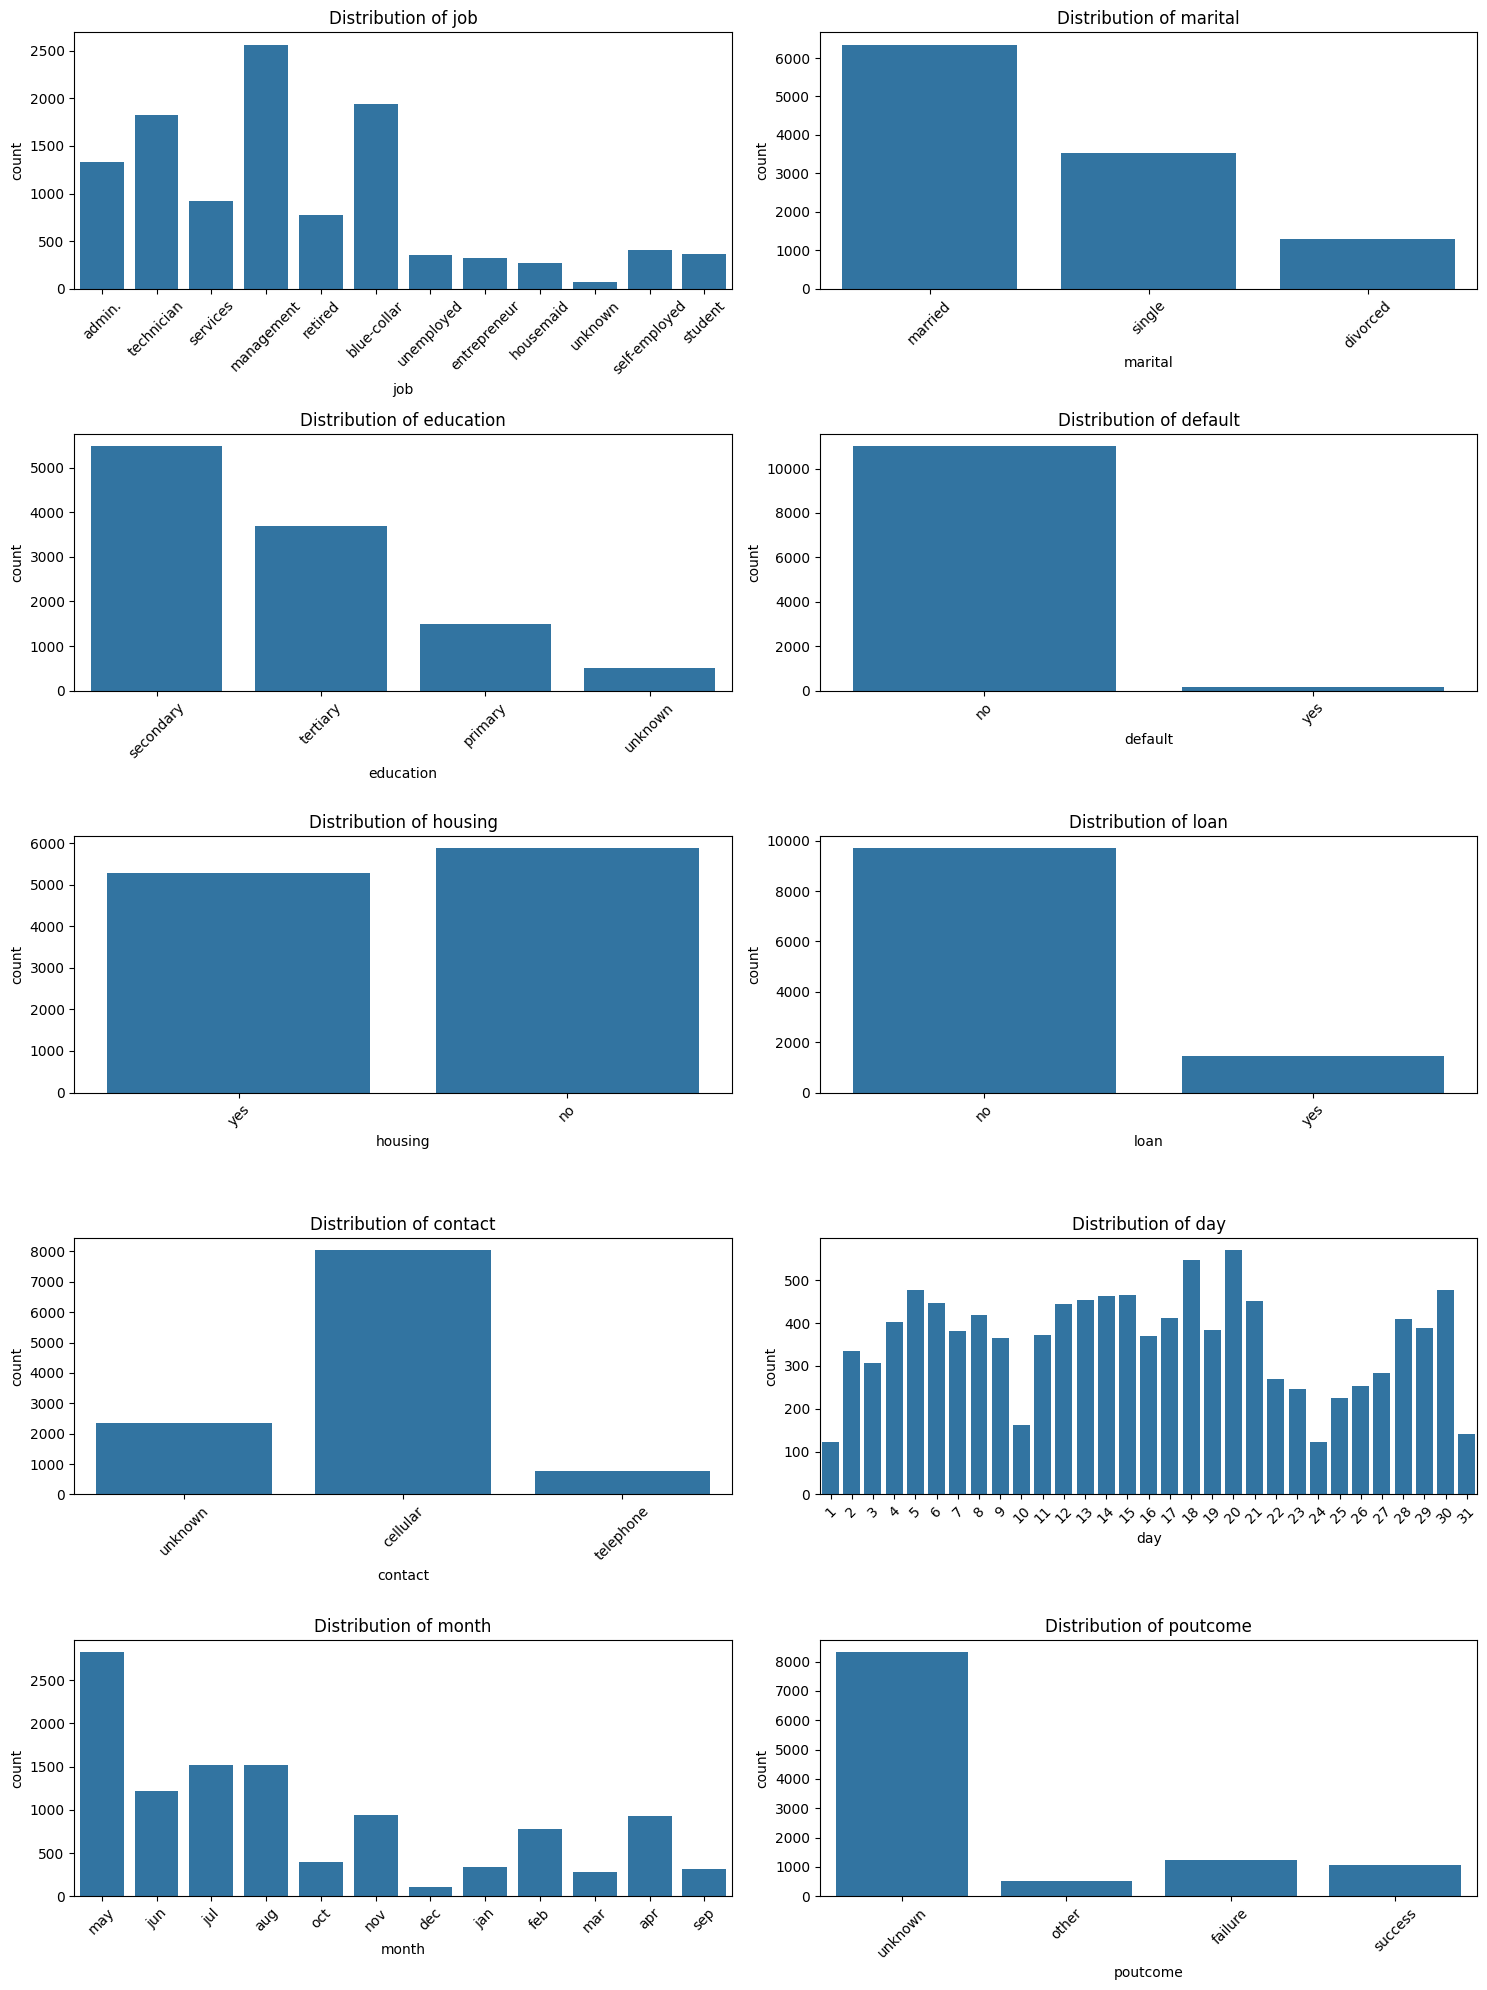

In [8]:
categorical_features = ["job", "marital", "education", "default", "housing", "loan", "contact", "day", "month",
                        "poutcome"]

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))

for ax, feature in zip(axes.ravel(), categorical_features):
    sns.countplot(data=data, x=feature, ax=ax)
    ax.set_title(f"Distribution of {feature}")
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()

We can also explore the proportion of missing values in the dataset. From the description, we know that only `contact`, `pdays`, and `poutcome` have missing values. For `contact` and `poutcome`, 'unknown' is used to denote missing values, while for `pdays`, -1 indicates that the client was not previously contacted. Let's now verify the proportion of these missing values.

Additionally, `job` and `education` also have 'unknown' values, but they are not considered missing values in the dataset description, so we will not include them in this analysis.

In [9]:
missing_contact = (data['contact'] == 'unknown').mean() * 100
missing_pdays = (data['pdays'] == -1).mean() * 100
missing_poutcome = (data['poutcome'] == 'unknown').mean() * 100
missing_job = (data['job'] == 'unknown').mean() * 100
missing_education = (data['education'] == 'unknown').mean() * 100

print(f"Proportion of missing values in 'contact': {missing_contact:.2f}%")
print(f"Proportion of missing values in 'pdays': {missing_pdays:.2f}%")
print(f"Proportion of missing values in 'poutcome': {missing_poutcome:.2f}%")
print(f"Proportion of 'unknown' values in 'job': {missing_job:.2f}%")
print(f"Proportion of 'unknown' values in 'education': {missing_education:.2f}%")

Proportion of missing values in 'contact': 21.02%
Proportion of missing values in 'pdays': 74.57%
Proportion of missing values in 'poutcome': 74.59%
Proportion of 'unknown' values in 'job': 0.63%
Proportion of 'unknown' values in 'education': 4.45%


Let's also explore the relationship between some of the features and the target variable. For numerical features, we can use boxplots to visualize the distribution of the feature values for each class of the target variable.

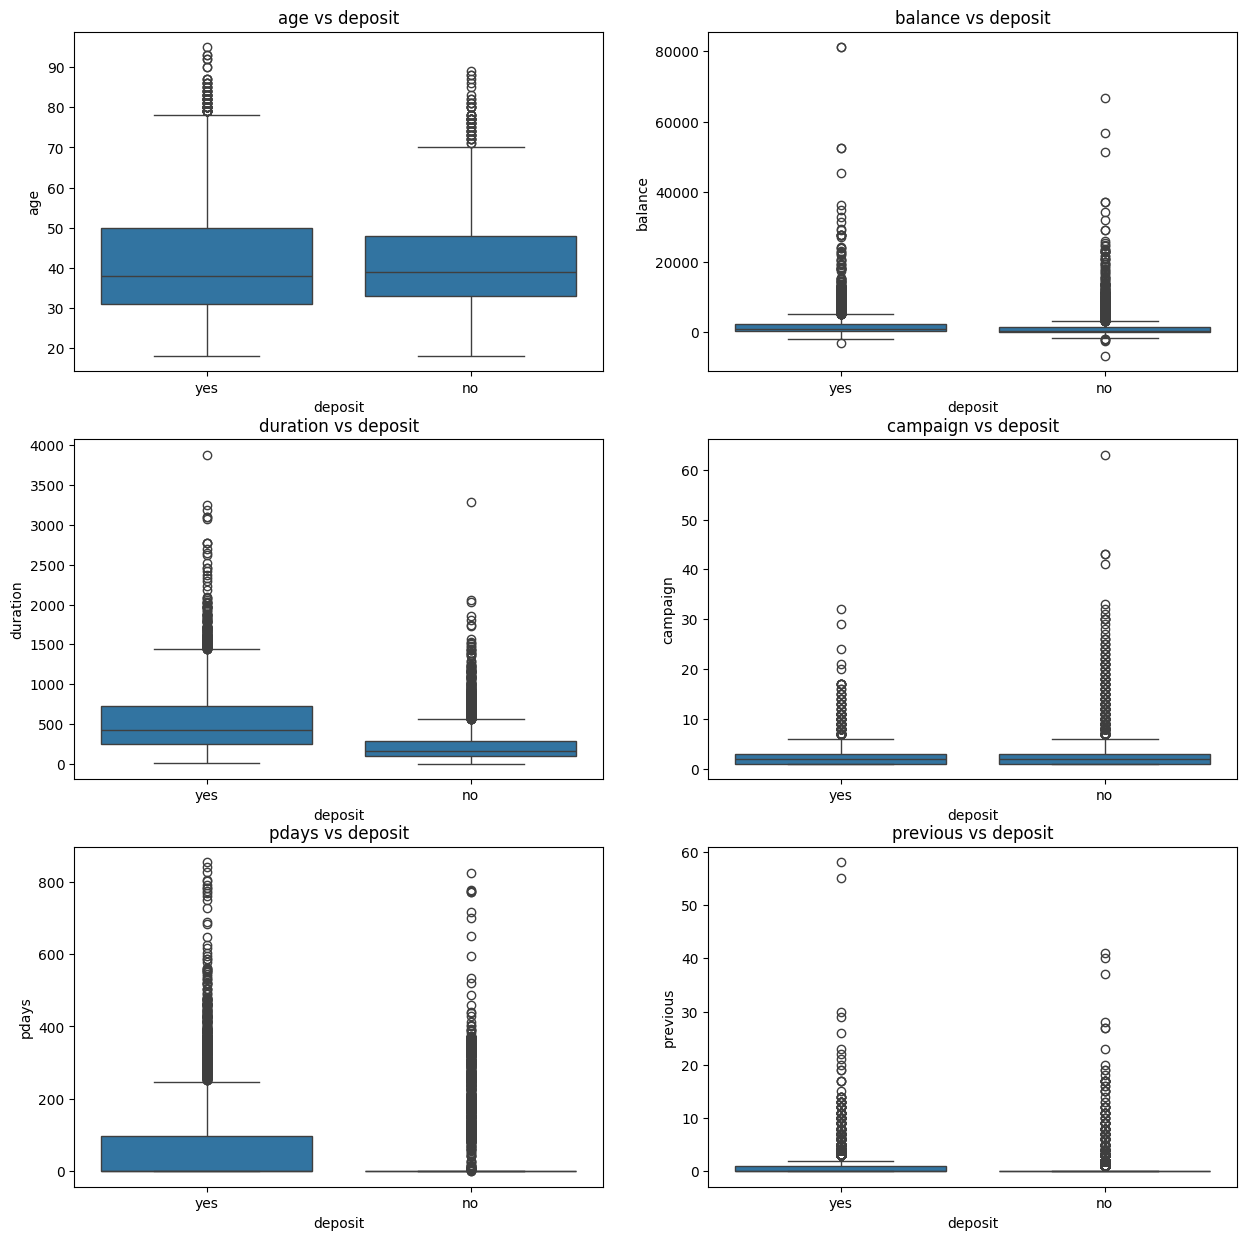

In [10]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))

for ax, feature in zip(axes.ravel(), numerical_features):
    sns.boxplot(data=data, x="deposit", y=feature, ax=ax)
    ax.set_title(f"{feature} vs deposit")

We can also use countplots to visualize the relationship between categorical features and the target variable.

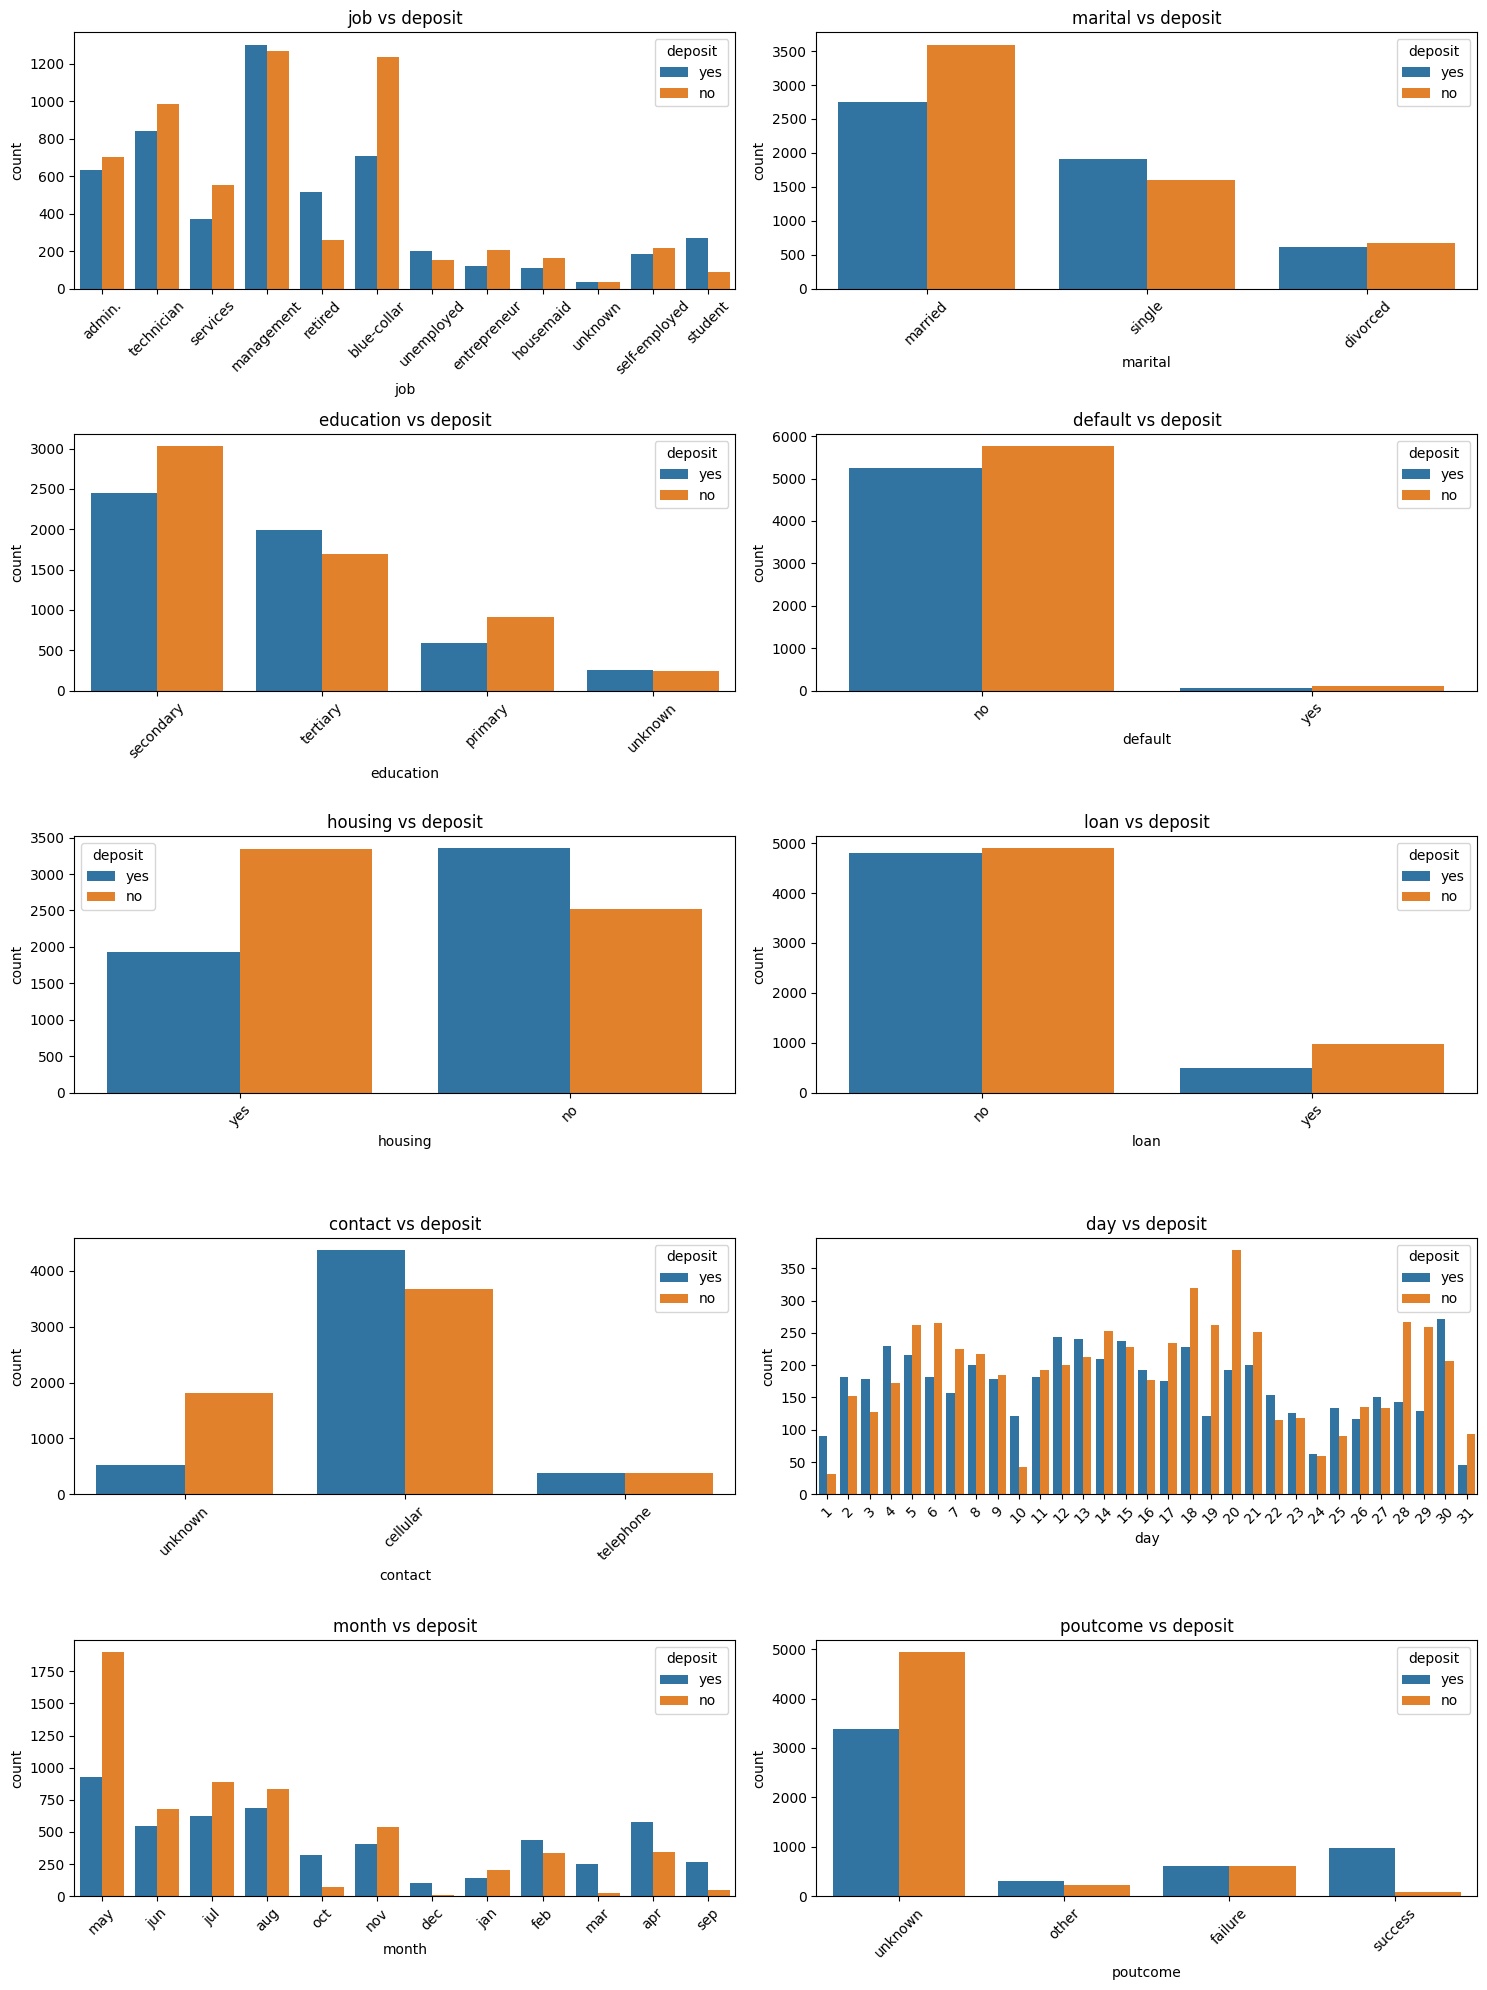

In [11]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))

for ax, feature in zip(axes.ravel(), categorical_features):
    sns.countplot(data=data, x=feature, hue="deposit", ax=ax)
    ax.set_title(f"{feature} vs deposit")
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()

Here we can derive a few insights from the visualizations:
- Clients with existing credits (`housing` and `loan`) are less likely to subscribe to a term deposit.
- Clients who previously subscribed to a term deposit (`poutcome`) are more likely to subscribe again. That said, the majority of clients have not been previously contacted, so this feature may not be very informative for our model.
- The duration of the last contact is much higher for clients who subscribed to a term deposit. However, as mentioned in the dataset description, this feature should be discarded for a realistic predictive model, since it is not known before a call is performed and it highly affects the target variable.
- The distribution of `balance` is also different for the two classes of the target variable, with clients who subscribed to a term deposit having a somewhat higher average balance. However, there are also some outliers in this feature, which may affect the performance of our model.
- Contact method also seems to have an impact on the target variable, with clients contacted via cellular being more likely to subscribe to a term deposit compared to those contacted via telephone. That said, there is also a significant proportion of missing values in this feature, which may affect its usefulness for our model. Also, cellular contact is more common in the dataset, so this feature may be somewhat imbalanced.

## Data preprocessing

Now that we have some understanding of the dataset, we can start with data preprocessing. We will create a pipeline to handle missing values, encode categorical features, and scale numerical features.

The first step is to separate the features and the target variable.

We will drop the `duration` feature as it is not known before a call is performed, and it highly affects the target variable, which would lead to an unrealistic predictive model. We are also dropping `pdays` and `poutcome` due to the high proportion of missing values, which may affect the performance of our model.

In [12]:
x = data.drop(columns=["deposit", "duration", "pdays", "poutcome"])
y = data["deposit"]

Before defining the preprocessing pipeline, we will perform a few simple transformations to the features:
- We will convert the `month` feature to a numerical representation, since it is an ordinal feature with a clear order (January to December).
- We will manually transform any column with `yes` and `no` values to binary 1 and 0, respectively, to simplify the encoding process in our pipeline. This includes our target variable `deposit`, which we will transform to a binary variable as well.
- For `education` and `job` features, we will replace 'unknown' values with the most frequent category in each feature, since 'unknown' is not a meaningful category and it may affect the performance of our model.
- For `education` specifically, we will manually encode the categories (primary, secondary, tertiary) to preserve the ordinal nature of this feature, which may be useful for our model.

Since these transformations are simple and do not require fitting any parameters, we will perform them outside of our preprocessing pipeline for simplicity. However, in a real-world scenario, it would be better to include all transformations in the pipeline to ensure that they are applied consistently to both the training and testing data.

In [13]:
y = y.map({"yes": 1, "no": 0})

x["month"] = x["month"].map({
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
    'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
})

binary_columns = ["default", "housing", "loan"]
for col in binary_columns:
    x[col] = x[col].map({"yes": 1, "no": 0})

x["education"] = x["education"].replace("unknown", x["education"].mode()[0])
x["job"] = x["job"].replace("unknown", x["job"].mode()[0])

x["education"] = x["education"].map({
    'primary': 1,
    'secondary': 2,
    'tertiary': 3,
})

We can now split the dataset into training and testing sets.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

Now, let's define our preprocessing pipeline. For numerical features, we will impute missing values with the median and apply a power transformation to reduce skewness. For categorical features, we will impute missing values with the most frequent category and apply one-hot encoding. We will also set `remainder="passthrough"` in the `ColumnTransformer` to ensure that any columns not specified in the transformers are passed through without transformation (in this case, there should not be any, but it's a good practice to include this parameter). Additionally, we will set `verbose_feature_names_out=False` to get more readable feature names after transformation.

In [15]:
preprocessing = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("num", make_pipeline(SimpleImputer(strategy="median"), PowerTransformer()),
             ["age", "balance", "campaign", "previous"]),
            ("cat", make_pipeline(SimpleImputer(strategy="most_frequent"), OneHotEncoder(handle_unknown="ignore")),
             ["marital", "contact", "job"])
        ],
        remainder="passthrough",
        verbose_feature_names_out=False
    )
)

Let's transform the training data using our preprocessing pipeline and take a look at the transformed features. Note that the output of the `ColumnTransformer` will be a NumPy array, so we will convert it back to a DataFrame for better readability, using the feature names generated by the transformers.

In [16]:
X_train = preprocessing.fit_transform(X_train)
feature_names = preprocessing.named_steps["columntransformer"].get_feature_names_out()
X_train = pd.DataFrame(X_train, columns=feature_names)
X_train.head()

,age,balance,campaign,previous,marital_divorced,marital_married,marital_single,contact_cellular,contact_telephone,contact_unknown,...,job_services,job_student,job_technician,job_unemployed,education,default,housing,loan,day,month
0,-1.288254,1.440574,1.434931,1.830018,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,10.0,9.0
1,-0.526827,-0.307910,0.878943,-0.577272,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,21.0,8.0
2,0.715215,-0.381555,-1.041703,1.500969,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,10.0,11.0
3,1.047190,0.299080,-1.041703,-0.577272,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,15.0,12.0
4,1.047190,0.183543,0.878943,1.882117,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,11.0,11.0


Let's repeat the same transformation for the testing data. Note that we will use `transform` instead of `fit_transform` to ensure that the same transformations are applied to the testing data as were learned from the training data.

In [17]:
X_test = preprocessing.transform(X_test)
X_test = pd.DataFrame(X_test, columns=feature_names)
X_test.head()

,age,balance,campaign,previous,marital_divorced,marital_married,marital_single,contact_cellular,contact_telephone,contact_unknown,...,job_services,job_student,job_technician,job_unemployed,education,default,housing,loan,day,month
0,1.697695,-0.142732,-1.041703,-0.577272,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,5.0,7.0
1,-0.111115,0.184589,1.833573,-0.577272,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,16.0,6.0
2,-0.417067,1.220943,-1.041703,1.500969,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,14.0,5.0
3,0.643284,2.111136,0.275043,-0.577272,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,8.0,8.0
4,-0.417067,0.130425,0.878943,-0.577272,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,3.0,0.0,1.0,0.0,12.0,5.0


## Model training and evaluation

Instructions: Complete this exercise by training a classification model on the preprocessed training data and evaluating its performance on the testing data using appropriate metrics such as accuracy, precision, recall, and F1-score.

Try with at least 3 different classification algorithms (e.g., Logistic Regression, Random Forest, Support Vector Machine) and compare their performance. For each of them, use GridSearchCV to find the best hyperparameters and report the results.

Lastly, compare the performance of the models and, for the best one (based on your chosen evaluation metric), display a confusion matrix and a classification report to analyze the results in more detail. 

### Defining objective metrics
For this classification task, the main evaluation metric will be the F1-score.

This dataset is imbalanced, there are many more clients who did not susbcribe than those who did. Because of that, accuracy would not be a good metric. A model could simply predict the majority class and still get a high accuracy, even if it fails to correctly identify potential subscribers.
So in this context, both types of errores matter. If the model predicts that a client will subscribe when they actually won't (false positive), the bank wastes times and operational resources. On the other hand, if the model fails to identify a client who would suscribe (false negative), the bank loses a potential revenue opportunity.

Using only precision would reduce unnecessary calls, but it might miss many real subscribers. Using only recall would detect more subscribers, but it would increase the number of wasted contacts. The F1-score combines precision and recall into a single metric, balancing both aspects. For this reason, it is the most appropriate metric for optimizing the campaign performance.

Therefore,F1-score will be used as the scoring metric during the GridSearchCV optimization process.

### Training and evaluating different models

#### Model 1 - Logistic Regression

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear'],
    'max_iter': [1000]
}

grid_search_lr = GridSearchCV(
    estimator=LogisticRegression(random_state=42),
    param_grid=param_grid_lr,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search_lr.fit(X_train, y_train)

print(f"Best parameters: {grid_search_lr.best_params_}")
print(f"Best CV F1-score: {grid_search_lr.best_score_:.4f}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'C': 1, 'max_iter': 1000, 'solver': 'lbfgs'}
Best CV F1-score: 0.6421


#### Model 2 - Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10]
}

grid_search_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search_rf.fit(X_train, y_train)

print(f"Best parameters: {grid_search_rf.best_params_}")
print(f"Best CV F1-score: {grid_search_rf.best_score_:.4f}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 100}
Best CV F1-score: 0.6861


#### Model 3 - Support Vector Machine

In [20]:
from sklearn.svm import SVC

param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

grid_search_svm = GridSearchCV(
    estimator=SVC(random_state=42),
    param_grid=param_grid_svm,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search_svm.fit(X_train, y_train)

print(f"Best parameters: {grid_search_svm.best_params_}")
print(f"Best CV F1-score: {grid_search_svm.best_score_:.4f}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Best CV F1-score: 0.6668


### Comparing model performance

The three best models are evaluated on the test set. Training set will also  identify overfitting or underfitting.

In [21]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

models = {
    'Logistic Regression': grid_search_lr,
    'Random Forest': grid_search_rf,
    'SVM': grid_search_svm
}

results = []
for name, gs in models.items():
    model = gs.best_estimator_
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    results.append({
        'Model': name,
        'Train Accuracy': round(accuracy_score(y_train, y_train_pred), 4),
        'Test Accuracy': round(accuracy_score(y_test, y_test_pred), 4),
        'Train F1': round(f1_score(y_train, y_train_pred), 4),
        'Test F1': round(f1_score(y_test, y_test_pred), 4),
        'Test Precision': round(precision_score(y_test, y_test_pred), 4),
        'Test Recall': round(recall_score(y_test, y_test_pred), 4),
        'CV F1 (mean)': round(gs.best_score_, 4)
    })

results_df = pd.DataFrame(results)
results_df.set_index('Model', inplace=True)
results_df

,Train Accuracy,Test Accuracy,Train F1,Test F1,Test Precision,Test Recall,CV F1 (mean)
Model,,,,,,,
Logistic Regression,0.6686,0.6901,0.6469,0.6754,0.6761,0.6748,0.6421
Random Forest,0.9086,0.7349,0.9007,0.7016,0.7590,0.6523,0.6861
SVM,0.7878,0.7282,0.7529,0.6793,0.7785,0.6026,0.6668


**Overfitting/Underfitting analysis**
To detect overfitting, training and test metrics are compared:
- If Train F1 is higher than Test F1, the model is likely overfitting.
- If both scores are low, the model is likely underfitting.
- If both scores are similar and moderately high, the model demonstrates good generalization.

Looking at the results, Random Forest shows the biggest gap between Train F1 and Test F1, which suggests some overfitting. It performs very well on the training data, but that performance drops a bit on unseen data. In comparison, Logistic Regression and SVM have smaller gaps, meaning they generalize more consistently.

However, Random Forest still achieves the highest F1-score on the test set. Since test performance is what matters most, it was selected as the best overall model.

### Best model 
The model with the best balance between test F1-score and overfitting is selected. The confusion matrix and classification report are shown below to provide a detailed performance analysis.

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

#best model based on Test F1
best_model_name = results_df['Test F1'].idxmax()
best_gs = models[best_model_name]
best_model = best_gs.best_estimator_

print(f"Best model: {best_model_name}")
print(f"Best hyperparameters: {best_gs.best_params_}")
print(f"F1-score in test: {results_df.loc[best_model_name, 'Test F1']:.4f}")
print(f"F1-score in train: {results_df.loc[best_model_name, 'Train F1']:.4f}")
print()

Best model: Random Forest
Best hyperparameters: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 100}
F1-score in test: 0.7016
F1-score in train: 0.9007



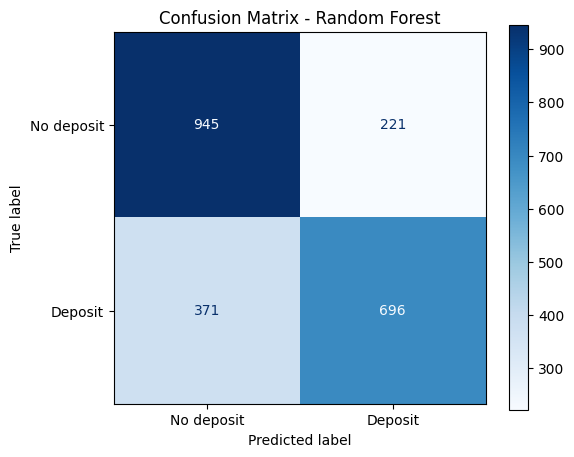

In [23]:
#confusion matrix
y_test_pred = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No deposit', 'Deposit'])

fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(ax=ax, cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.show()

**Observations**

The confusion matrix shows that the model correctly classified 945 non-subscribers (TN) and 696 subscribers (TP). However, it missed 371 actual subscribers (False Negatives), meaning those clients would not be contacted even though they were likely to subscribe. From a business point of view, this is the most critical mistake because it represents lost opportunities.

There are also 221 False Positives (clients predicted to subscribe who actually wouldn’t). These lead to unnecessary calls, but the cost is mainly operational. In general, the model tends to predict the negative class more often, which is why its precision is higher than its recall.

In [24]:
#classification report
print(f"Classification Report-{best_model_name}")
print("-" * 60)
print(classification_report(y_test, y_test_pred, target_names=['No deposit', 'Deposit']))

Classification Report-Random Forest
------------------------------------------------------------
              precision    recall  f1-score   support

  No deposit       0.72      0.81      0.76      1166
     Deposit       0.76      0.65      0.70      1067

    accuracy                           0.73      2233
   macro avg       0.74      0.73      0.73      2233
weighted avg       0.74      0.73      0.73      2233



**Observations**
The classification report shows the same pattern. The model performs better on the “No deposit” class, especially in terms of recall, meaning it is more accurate at identifying clients who won’t subscribe. For the “Deposit” class, precision is acceptable, but recall is lower, which means the model is missing many actual subscribers.

This likely happens because the dataset is imbalanced, so the model was exposed to more “No deposit” cases during training and tends to lean toward that prediction. 

### Final remarks

In this activity, the Bank Marketing classification problem was analyzed by training and comparing three models: Logistic Regression, Random Forest, and Support Vector Machine. Hyperparameters were optimized using GridSearchCV with 5-fold cross-validation. Each model was trained five times, using a different part for validation each time. This helps ensure that the results are more reliable and not dependent on a single data split.

F1-score was selected as the optimization metric because the dataset is imbalanced and both types of misclassification have important business consequences. False positives lead to unnecessary contact with uninterested clients, increasing operational costs, while false negatives mean missing potential subscribers and losing revenue opportunities.

By comparing performance on the training and test sets, each model’s ability to generalize was evaluated and potential overfitting was identified. In particular, Random Forest showed a larger gap between training and test performance, suggesting a higher tendency to overfit compared to the other models.

The final selected model, evaluated through its confusion matrix and classification report, achieves a good balance between precision and recall on the test set. This allows the bank to better identify clients who are more likely to subscribe, improving campaign efficiency and overall return on investment.